# Store Item Demand Forecasting

Neste kernel, utilizo um conjunto de dados que contém as vendas diárias dos produtos de uma rede de lojas. No total são 10 lojas, cada uma, vendendo 50 produtos diferentes. O conjunto contém registros de 2013 até 2017. A tarefa é fazer previsões de vendas de cada produto de cada loja para os próximos três meses.


Fonte: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/code

# Initial imports

In [ ]:
%pip install ipython-autotime --upgrade
#%pip install scikit-learn     --upgrade

In [1]:
from google.colab import drive, files
import pandas as pd
import warnings
drive.mount('/content/drive', force_remount=True)
warnings.filterwarnings("ignore")
%load_ext autotime

Mounted at /content/drive
time: 489 µs (started: 2023-06-14 17:22:29 +00:00)


In [2]:
dataset = pd.read_csv("/content/drive/MyDrive/datasets/store-item-demand-forecasting/train.csv", encoding='utf-8', parse_dates=['date'])

time: 1.09 s (started: 2023-06-14 17:22:33 +00:00)


# EDA

In [3]:
dataset

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


time: 51.7 ms (started: 2023-06-14 17:22:36 +00:00)


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
time: 38.2 ms (started: 2023-06-14 17:22:40 +00:00)


A tarefa é prever os três meses seguintes de vendas, mas o conjunto de dados contém registros diários. Vou transformá-lo para registros mensais. Normalmente eu faço transformações nos dados na fase de engenharia de atributos, mas como esse tipo de transformação vai influenciar até mesmo a visualização de dados, farei logo no início da análise exploratória.

**Etapa ##:** Mantenho somente os anos e meses nas datas. Os dias(01) aparecem porque são definidos por padrão.

In [5]:
#dataset['date'] = dataset['date'].dt.strftime('%Y-%m') # o novo atributo se transforma em object.
#dataset["date"] = pd.to_datetime(dataset["date"])

dataset['date'] = dataset['date'].dt.to_period('M') # o novo atributo se transforma em period[M].
dataset['date'] = pd.PeriodIndex(dataset['date'], freq='M').to_timestamp()

time: 201 ms (started: 2023-06-14 17:22:44 +00:00)


**Etapa ##:** Somo a quantidade de vendas de cada item em cada loja mensalmente.

In [6]:
dataset = dataset.groupby(['store', 'item', 'date'])['sales'].sum().reset_index()
dataset = dataset[['date', 'store', 'item', 'sales']] # reordeno as colunas para ficar mais legível
dataset

,date,store,item,sales
0,2013-01-01,1,1,328
1,2013-02-01,1,1,322
2,2013-03-01,1,1,477
3,2013-04-01,1,1,522
4,2013-05-01,1,1,531
...,...,...,...,...
29995,2017-08-01,10,50,2867
29996,2017-09-01,10,50,2586
29997,2017-10-01,10,50,2507
29998,2017-11-01,10,50,2574


time: 132 ms (started: 2023-06-14 17:22:48 +00:00)


**Etapa ##:** Defino as datas como sendo o index do dataframe.

In [7]:
dataset = dataset.set_index('date')

time: 2.19 ms (started: 2023-06-14 17:22:52 +00:00)


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30000 entries, 2013-01-01 to 2017-12-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   store   30000 non-null  int64
 1   item    30000 non-null  int64
 2   sales   30000 non-null  int64
dtypes: int64(3)
memory usage: 937.5 KB
time: 40.2 ms (started: 2023-06-14 17:22:54 +00:00)


In [9]:
dataset.describe()

,store,item,sales
count,30000.000000,30000.00000,30000.000000
mean,5.500000,25.50000,1590.150400
std,2.872329,14.43111,824.119569
min,1.000000,1.00000,211.000000
25%,3.000000,13.00000,925.000000
50%,5.500000,25.50000,1449.000000
75%,8.000000,38.00000,2112.000000
max,10.000000,50.00000,5109.000000


time: 65.6 ms (started: 2023-06-14 17:22:55 +00:00)


## Data visualization

Vou usar nessa etapa um modelo de regressão linear para capturar a tendêndia das distribuições que pretendo visualizar. Através dele posso desenhar a linha da tendência nos gráficos.

In [10]:
from sklearn.linear_model import LinearRegression

import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

np.random.default_rng()

colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

time: 2.16 s (started: 2023-06-14 17:22:59 +00:00)


Considerando um ano, loja, e item quaisquer, vou fazer uma visualização mensal para verificar se há alguma sazonalidade ou tendência.

As funções da célula abaixo são úteis para fazer as visualizações. Além disso, o ideal seria criar gráficos de boa parte dos itens e lojas, mas como seriam 500 gráficos(50 itens e 10 lojas), preferi fazer de outro jeito.

As funções abaixo permitem que cada vez que a célula que contiver o código de visualização seja executado um novo gráfico seja criado. Este será referente a um item aleatório de uma loja aleatória podendo ser de um ano ano qualquer ou do histórico completo.

In [11]:
def get_date_range(sample):
  """
  Obtém um objeto do tipo date_rage com 'freq' definida em 'MS'.
  Isso será fundamental para formar um ps.Series que será usado pela classe do sktime ForecastingHorizon.
  """
  start_date = sample.index[0]
  index_end  = sample.index[-1]
  return pd.date_range(start=start_date, end=index_end, freq='MS')



def get_sample_sales(dataset, one_year=True):
  """
  Forma um pd.Series com uma amostra de um ano de vendas.
  """
  #dataset       = dataset.copy()
  #dataset.index = dataset.index.to_timestamp()

  dataset_sample = random_sample_sales(dataset, one_year)
  date_range     = get_date_range(dataset_sample)

  sales       = dataset_sample['sales']
  sales.index = date_range
  return sales



def random_sample_sales(dataset, one_year=True):
  """
  Obtém uma amostra aleatória correspondente a um ano de vendas do dataset ou ao histórico interio.
  """
  store = np.random.randint(1, 11)
  item  = np.random.randint(1, 51)
  year  = np.random.randint(2013, 2018)

  if one_year:
    mask  = (dataset.index.year == year) & (dataset['store'] == store) & (dataset['item'] == item)
  else:
    mask  = (dataset['store'] == store) & (dataset['item'] == item)
  return dataset[mask]

time: 1.43 ms (started: 2023-06-14 17:23:01 +00:00)


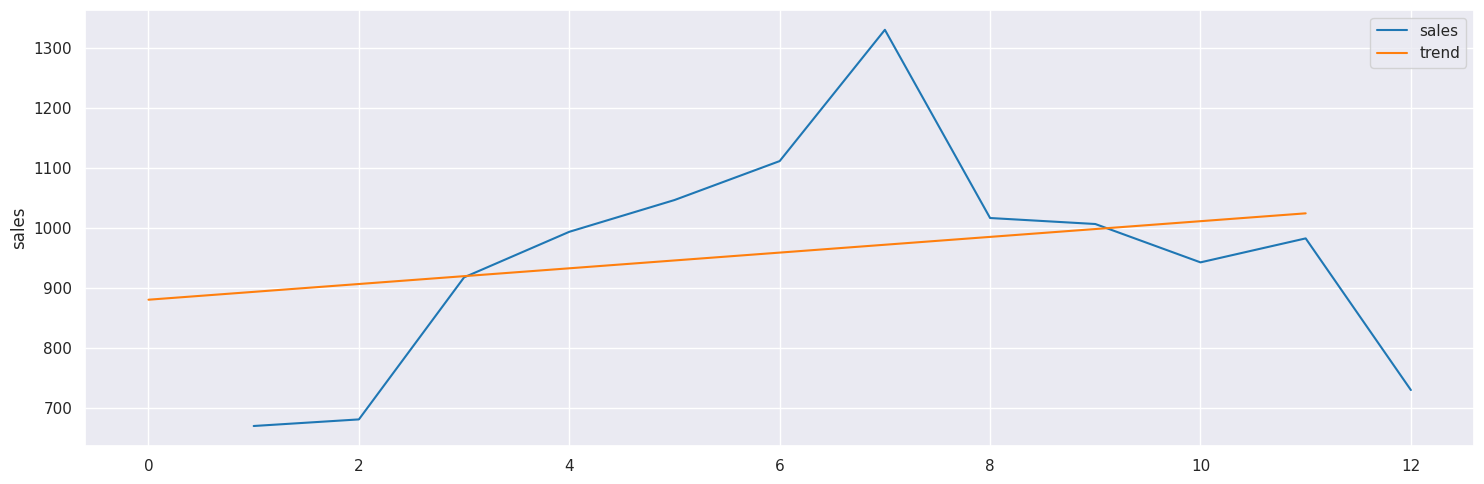

time: 2.08 s (started: 2023-06-14 17:23:02 +00:00)


In [12]:
sales = get_sample_sales(dataset, one_year=True)
sales.index = np.arange(1, 13) # pequeno ajuste para o modelo funcionar, as datas são substituídas por meses [1, 12]

lr = LinearRegression()
lr.fit(sales.index.to_numpy().reshape(-1, 1), sales.values)
y_pred = lr.predict(sales.index.to_numpy().reshape(-1, 1))

sns.set(rc={'figure.figsize':(15, 5)})
axs = sns.lineplot(data=sales, color=colors[0], label='sales')
sns.lineplot(data=y_pred, color=colors[1], label='trend', ax=axs)

plt.tight_layout()
plt.show()

**Conclusão:** Executando várias vezes a célula acima podemos concluir que não há sazonlidade mensal de vendas e conseguimos identificar uma leve tendência crescente em alguns anos.

Há, no entanto, um pico de vendas sempre em torno do mês 7. Considerando que esse conjunto de dados é americano, esse padrão se deve, provavelmente, por causa do verão e das férias.

Agora, vou escolher uma loja e um item qualquer para analisar o histórico de vendas ao longo de todos os anos registrados mês a mês.

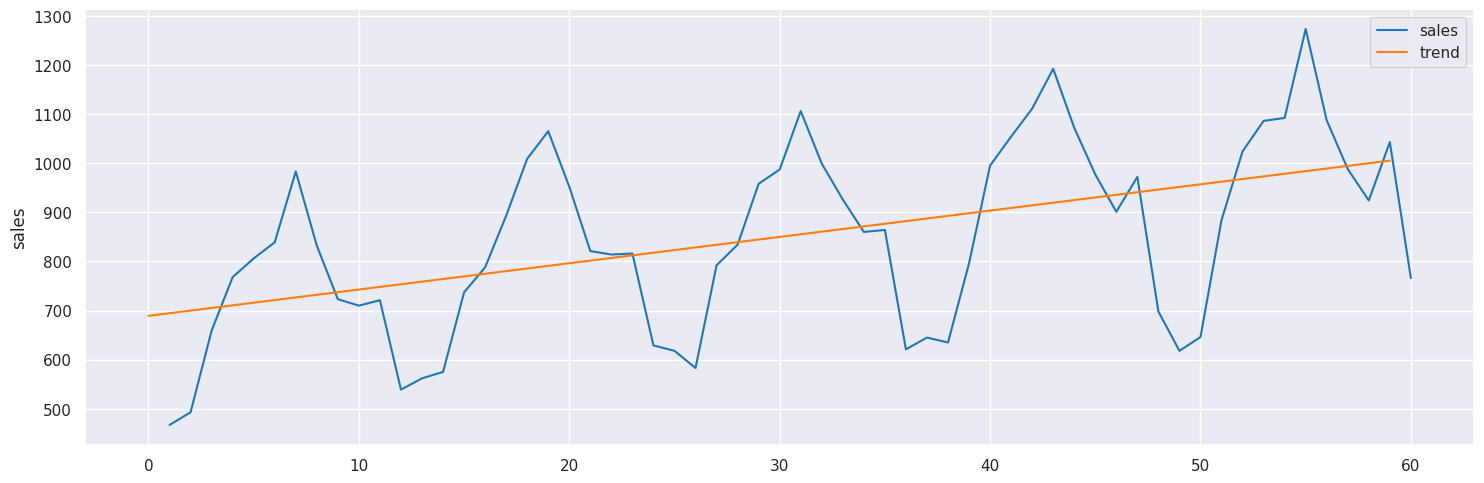

time: 466 ms (started: 2023-06-14 17:23:07 +00:00)


In [13]:
sales = get_sample_sales(dataset, one_year=False)
sales.index = np.arange(1, (len(sales) + 1))

lr = LinearRegression()
lr.fit(sales.index.to_numpy().reshape(-1, 1), sales.values)
y_pred = lr.predict(sales.index.to_numpy().reshape(-1, 1))

sns.set(rc={'figure.figsize':(15, 5)})
axs = sns.lineplot(data=sales, color=colors[0], label='sales')
sns.lineplot(data=y_pred, color=colors[1], label='trend', ax=axs)

plt.tight_layout()
plt.show()

**Conclusão:** Executando várias vezes a célula acima, é possível observar sazonalidade ao longo dos anos com picos sempre por volta do mês 7 e vales sempre no ínicio e fim de cada ano. Também conseguimos ver uma leve tendência de aumento de vendas no decorrer do tempo.

# Train/Test split

Meu conjunto de teste será correspondente a um ano. Como sei que o último ano é 2017, vou usar os 12 meses dele.

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

time: 643 µs (started: 2023-06-14 17:24:53 +00:00)


In [15]:
mask = dataset.index.year < 2017

train_set = dataset[mask]
test_set  = dataset[~mask]

time: 8.58 ms (started: 2023-06-14 17:24:55 +00:00)


As linhas verticais do gráfico abaixo representam cada mês do ano.

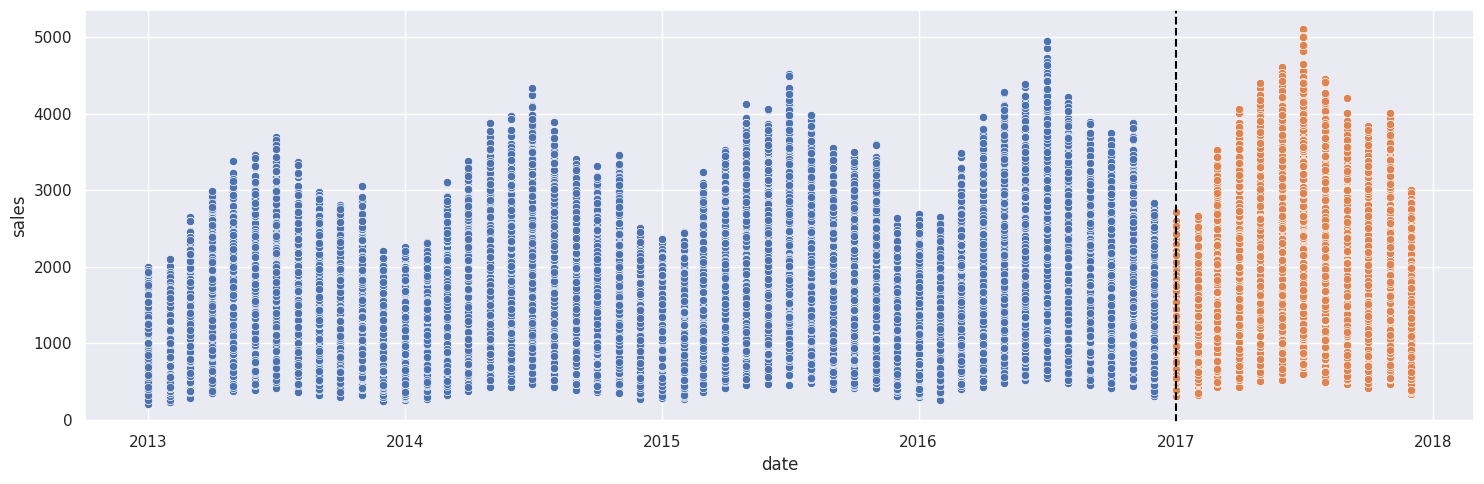

time: 2.31 s (started: 2023-06-14 17:24:58 +00:00)


In [16]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5), sharex=True)

axs.axvline(test_set.index.min(), color='black', ls='--')
sns.scatterplot(x=train_set.index, y=train_set['sales'], ax=axs)
sns.scatterplot(x=test_set.index, y=test_set['sales'], ax=axs)

plt.tight_layout()
plt.show()

A classe abaixo servirá para criar lag e forward features na etapa de feature engineering. Vou usá-la aqui para criar as labels(forward features) representando a quantidade de vendas feitas no primeiro, segundo e terceiro mês seguinte.

In [17]:
class LagForwardFeatures(BaseEstimator, TransformerMixin):
  """
  Cria uma quantidade n de lag ou forward features.
  """
  def __init__(self, lag_size=0):
    if lag_size < 0:
      self.init = lag_size
      self.end  = 0
      self.lag_forward = 'forward'
    else:
      self.init = 1
      self.end  = lag_size + 1
      self.lag_forward = 'lag'

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    X = X.copy()
    for i in range(self.init, self.end):
      col_name = 'sales_' + self.lag_forward + '_' + str(np.abs(i))
      X[col_name] = X.groupby(['store', 'item'])['sales'].shift(i)
    return X

time: 1.52 ms (started: 2023-06-14 17:25:03 +00:00)


In [18]:
fwrd_feat = LagForwardFeatures(lag_size=-3)
train_set = fwrd_feat.fit_transform(train_set)
test_set  = fwrd_feat.transform(test_set)

y_train   = train_set[['sales_forward_1', 'sales_forward_2', 'sales_forward_3']]
X_train   = train_set.drop(['sales_forward_1', 'sales_forward_2', 'sales_forward_3'], axis=1)

y_test    = test_set[['sales_forward_1', 'sales_forward_2', 'sales_forward_3']]
X_test    = test_set.drop(['sales_forward_1', 'sales_forward_2', 'sales_forward_3'], axis=1)

time: 98.7 ms (started: 2023-06-14 17:25:06 +00:00)


Por causa do seu mecanismo, um efeito potencialmente problemático das lag features é que elas possuem valores NaN nas suas extremidades. Para atenuar esse problema, vou imputar o número zero nesses registros. Não é a melhor estratégia, mas não será catastrófica.

Além disso, vou ordenar os conjuntos de treinamento e teste por ordem de data. Isso não vai afetar a engenharia de atributos, mas vai fazer diferença no treinamento dos modelos.

In [19]:
y_train   = y_train.fillna(0)
y_test    = y_test.fillna(0)

X_train = X_train.sort_index()
X_test  = X_test.sort_index()

y_train = y_train.sort_index()
y_test  = y_test.sort_index()

time: 36 ms (started: 2023-06-14 17:25:12 +00:00)


# Feature engineering.

In [20]:
from scipy.stats             import boxcox
from sklearn.compose         import ColumnTransformer
from sklearn.impute          import SimpleImputer
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import MinMaxScaler, OrdinalEncoder, PowerTransformer

import math

time: 84 ms (started: 2023-06-14 17:25:15 +00:00)


**Etapa ##:** Crio lag features com os três meses de vendas anteriores.


In [21]:
pp_lag = Pipeline(steps=[('lag_features', LagForwardFeatures(lag_size=3))])

time: 699 µs (started: 2023-06-14 17:25:16 +00:00)


**Etapa ##:** Extraio novos atributos a partir das datas. Não extraio os dias porque, agora, o dataset é mensal.
1.   Ano
2.   Mês
4.   Estações do ano
5.   Quartis de cada ano.


In [22]:
class DatesFeatures(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_season(self, month):
    if month in [12, 1, 2]:
      return "Winter"
    elif month in [3, 4, 5]:
      return "Spring"
    elif month in [6, 7, 8]:
      return "Summer"
    else:
      return "Fall"

  def transform(self, X, y=None):
    X = X.copy()
    #X = X.assign(season=X.index.month.map(self.get_season))
    X['year']    = X.index.year
    X['month']   = X.index.month
    X['season']  = np.vectorize(self.get_season)(X.index.month)
    X['quarter'] = X.index.to_period('Q')
    return X

time: 1.33 ms (started: 2023-06-14 17:25:17 +00:00)


In [23]:
pp_dates = Pipeline(steps=[('dates_features', DatesFeatures())])

time: 789 µs (started: 2023-06-14 17:26:48 +00:00)


**Etapa ##:** Crio atributos contendo a diferença de vendas entre o mês corrente e os três meses anteriores e outras medidas estatísticas, como:

*   Maior valor entre a quantidade de vendas corrente e as dos três meses anteriores.
*   Menor valor entre a quantidade de vendas corrente e as dos três meses anteriores.
*   Média de vendas entre a corrente e as dos três meses anteriores.
*   Desvio padrão de vendas entre a corrente e as dos três meses anteriores.

Essas medidas estatísticas podems ajudar o modelo preditor, mas não é uma certeza.

In [24]:
class StatisticSales(BaseEstimator, TransformerMixin):
  """
  Calcula estatísticas de um conjunto de dados, como:
  * diferença entre o valor corrente e n passos atrás
  * max(), min(), mean(), std() entre o valor atuale n passos atrás
  """
  def __init__(self, size=0):
    self.size = size + 1

  def fit(self, X, y=None):
    return self

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def get_diff(self, X, y=None):
    for i in range(1, self.size):
      col_name = 'sales_diff_' + str(i)
      X[col_name] = X.groupby(['store', 'item'])['sales'].diff(i)
    return X

  def get_stats(self, X, y=None):
    X = X.sort_values(['store', 'item']) # se eu não fizer isso,  recebo: "ValueError: cannot reindex on an axis with duplicate labels"
    for i in range(2, self.size + 1): # precisa ser +1 porque rolling considera também a linha corrente
      max_name  = 'sales_max_'  + str(i - 1)
      min_name  = 'sales_min_'  + str(i - 1)
      mean_name = 'sales_mean_' + str(i - 1)
      std_name  = 'sales_std_'  + str(i - 1)
      X[max_name]  = X.groupby(['store', 'item'])['sales'].rolling(i).max().reset_index(level=[0, 1], drop=True)
      X[min_name]  = X.groupby(['store', 'item'])['sales'].rolling(i).min().reset_index(level=[0, 1], drop=True)
      X[mean_name] = X.groupby(['store', 'item'])['sales'].rolling(i).mean().reset_index(level=[0, 1], drop=True)
      X[std_name]  = X.groupby(['store', 'item'])['sales'].rolling(i).std().reset_index(level=[0, 1], drop=True)
    return X.sort_index() # reordena os registros por ordem de data antes de retornar

  def transform(self, X, y=None):
    X = X.copy()
    X = self.get_diff(X)
    X = self.get_stats(X)
    return X

time: 1.87 ms (started: 2023-06-14 17:26:51 +00:00)


In [25]:
pp_stats = Pipeline(steps=[('stats_features', StatisticSales(size=3))])

time: 607 µs (started: 2023-06-14 17:26:55 +00:00)


**Etapa ##:** O conjunto de dados possui datas de 2013 até 2017 se repetindo em ciclos inúmeras vezes. Isso acontece por causa das lojas e itens. Para fazer com que os modelos de machine learning entendam esses ciclos eu codifico os atributos cíclicos(year, month, season, quarter) decompondo-os em componentes seno e conseno. Só depois disso posso remover os atributos 'year', 'month', 'season' e 'quarter' do conjunto.

In [26]:
class CyclicEncoder(OrdinalEncoder):
  """
  Esta classe deve ser usada sozinha ou dentro de um Pipeline.
  """
  def __init__(self, cyclical_cols):
    super().__init__(handle_unknown='use_encoded_value', unknown_value=-1)
    self.cyclical_cols = cyclical_cols

  def create_cyclic_names(self):
    cols_names = []
    for name in self.cyclical_cols:
      cols_names.append("sin_" + name)
      cols_names.append("cos_" + name)
    return cols_names

  def fit(self, X, y=None):
    return super().fit(X[self.cyclical_cols])

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X, y)

  def transform(self, X, y=None):
    X_ordinal = super().transform(X[self.cyclical_cols])
    X_aux = []
    cols = range(X_ordinal.shape[1])
    for index in cols:
      column = X_ordinal[:, index]
      max_value = column.max()
      sin_values = [math.sin((2 * math.pi * x) / max_value) for x in list(column)]
      cos_values = [math.cos((2 * math.pi * x) / max_value) for x in list(column)]
      X_aux.append(sin_values)
      X_aux.append(cos_values)
    X_encoded = np.array(X_aux).transpose()
    cyclical_features = pd.DataFrame(data=X_encoded, columns=self.create_cyclic_names())
    cyclical_features = cyclical_features.set_index(X.index)
    X = pd.concat([cyclical_features, X], axis=1)
    return X.drop(self.cyclical_cols, axis=1)

time: 2.02 ms (started: 2023-06-14 17:26:59 +00:00)


In [27]:
pp_cyclical = Pipeline(steps=[('cyclical_encoding', CyclicEncoder(['year', 'month', 'season', 'quarter']))])

time: 736 µs (started: 2023-06-14 17:27:04 +00:00)


**Etapa ##:** Imputo valores nos registros que contém NaN.

In [28]:
pp_imputer = Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='constant', fill_value=0))])

time: 713 µs (started: 2023-06-14 17:27:04 +00:00)


**Etapa ##:** Escalono o conjunto para que seus valores fiquem no intervalo [0, 1]. Vou fazer um pequeno ajuste na classe MinMaxScaler para que após o escalonamento todos os valores do conjnuto sejam acrescidos +1. Isso garantirá que todos sejam positivos e assim poderei normalizá-los com BoxCox.

In [29]:
class CustomMinMaxScaler(MinMaxScaler):
  def fit(self, X, y=None):
    return super().fit(X, y)

  def fit_transform(self, X, y=None):
    self.fit(X, y)
    return self.transform(X)

  def transform(self, X, y=None):
    X = super().transform(X)
    return (X + 1)

time: 1.16 ms (started: 2023-06-14 17:27:05 +00:00)


In [30]:
pp_scaler = Pipeline(steps=[('custom_min_max_scaler', CustomMinMaxScaler())])

time: 740 µs (started: 2023-06-14 17:27:09 +00:00)


**Etapa ##:** Normalizo a distribuição de dados coluna a coluna utilizando a técnica boxcox. Isso fará com que cada coluna tenha uma distribuição próxima da distribuição normal.

In [31]:
pp_boxcox = Pipeline(steps=[('boxcox', PowerTransformer(method='box-cox'))])

time: 632 µs (started: 2023-06-14 17:27:55 +00:00)


## Etapa final: Pipeline completo

In [32]:
steps = [('pp_lag', pp_lag),
         ('pp_dates', pp_dates),
         ('pp_stats', pp_stats),
         ('pp_cyclical', pp_cyclical),
         ('pp_imputer', pp_imputer),
         ('pp_scaler', pp_scaler),
         ('pp_boxcox', pp_boxcox), ]

pipeline_full = Pipeline(steps=steps)
X_train_       = pipeline_full.fit_transform(X_train)
X_test_        = pipeline_full.transform(X_test)

time: 2.14 s (started: 2023-06-14 17:27:55 +00:00)


# Model training

A tarefa tratada neste kernel é multilabel ou multitarget, ou seja, uma label para cada mês dos próximos três meses de previsões. O problema é que muitos modelos não suportam esse tipo de regressão nativamente. Por isso, vou usar a classe MultiOutputRegressor que vai fazer essa adaptação treinando um regressor por label.

Vou escolher dois modelos baseados em árvores e dois modelos neurais para o treinamento.

*   LightGBMRegressor
*   XGBRegressor
*   Neural Network - Dense layers
*   LSTM - Long Short-Term Memory







In [33]:
from keras                   import optimizers
from keras.callbacks         import EarlyStopping, ReduceLROnPlateau
from keras.layers            import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from keras.models            import Sequential, Model
from keras.optimizers        import Nadam
from keras.utils             import plot_model

from sklearn.base            import clone
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput     import MultiOutputRegressor
from xgboost                 import XGBRegressor

import lightgbm as lgb

time: 4.86 s (started: 2023-06-14 17:28:19 +00:00)


## Custom cost function

A função de custo SMAPE(Symmetric Mean Absolute Percentage Error) não possui implementação no Scikit-Learn, por isso implemento aqui.

In [34]:
def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error between the true and predicted values.

    Returns (The lower the better):
    float: The SMAPE score between 0 and 100.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    numerator = np.abs(y_pred - y_true)

    return np.mean(numerator / denominator) * 100

time: 849 µs (started: 2023-06-14 17:28:24 +00:00)


## Cross validation

A validação cruzada será realizada no conjunto de treinamento. Como ele é menor que o total, na validação cruzada, vou precisar reajustar o tamanho do conjunto de validação, caso contrário, terei poucos folds para fazer as validações. Por isso, escolhi o equivalente a 9(4500 registros) meses para validação e o restante para treinamento além de um intervalo de 3(1500 registros) meses.

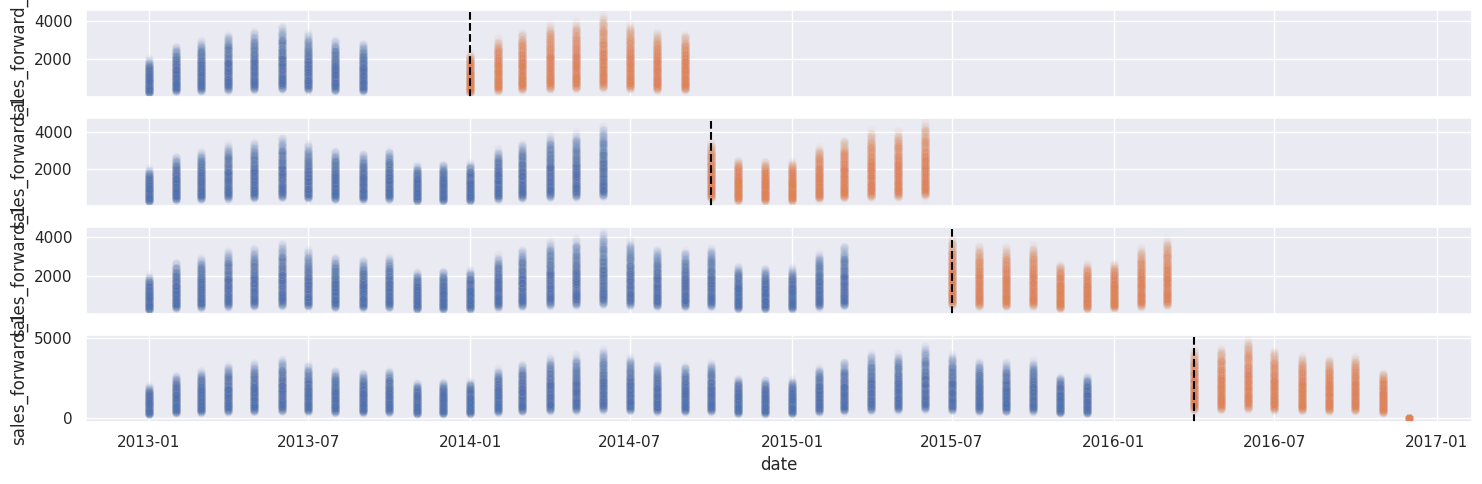

time: 2.47 s (started: 2023-06-14 17:28:30 +00:00)


In [35]:
def show_cross_val_folds(y):
  """
  Essa função usa apenas a label(y) porque é usada apenas para a visualização dos folds.
  """
  tss = TimeSeriesSplit(n_splits=4, test_size=4500, gap=1500)

  fig, axs = plt.subplots(4, 1, figsize=(15, 5), sharex=True)
  axs = axs.ravel()
  index = 0

  for train_indexes, test_indexes in tss.split(y):
    train_set = y.iloc[train_indexes]
    test_set  = y.iloc[test_indexes]
    axs[index].axvline(test_set.index.min(), color='black', ls='--')
    sns.scatterplot(x=train_set.index, y=train_set['sales_forward_1'], ax=axs[index], alpha=0.03)
    sns.scatterplot(x=test_set.index, y=test_set['sales_forward_1'], ax=axs[index], alpha=0.03)
    index += 1

  plt.tight_layout()
  plt.show()



show_cross_val_folds(y_train)

In [36]:
def custom_cross_val(model, X, y, pipeline):
  tss = TimeSeriesSplit(n_splits=4, test_size=4500, gap=1500)

  scores_smape = list()
  scores_mse   = list()
  for train_indexes, valid_indexes in tss.split(X):
    X_train  = X.iloc[train_indexes]
    X_valid  = X.iloc[valid_indexes]
    y_train  = y.iloc[train_indexes]
    y_valid  = y.iloc[valid_indexes]

    X_train_ = pipeline.fit_transform(X_train)
    X_valid_ = pipeline.transform(X_valid)

    model_clone = clone(model)
    model_clone.fit(X_train_, y_train)

    y_pred = model_clone.predict(X_valid_)
    scores_smape.append(smape(y_valid, y_pred))
    scores_mse.append(mean_squared_error(y_valid, y_pred))
  return scores_smape, scores_mse

time: 1.18 ms (started: 2023-06-14 17:28:38 +00:00)


Os primeiros folds da validação cruzada são tão pequenos alguns atributos acabam se tornando constantes. A classe PowerTransformer não permite esse tipo de atributo, por isso removi ela do pipeline.

In [37]:
steps_cv = [('pp_lag', pp_lag),
            ('pp_dates', pp_dates),
            ('pp_stats', pp_stats),
            ('pp_cyclical', pp_cyclical),
            ('pp_imputer', pp_imputer),
            ('pp_scaler', pp_scaler), ]

pipeline_cv = Pipeline(steps=steps_cv)

time: 904 µs (started: 2023-06-14 17:28:43 +00:00)


## Visualizations

Função para visualização dos resultados.

In [38]:
def show_predictions(y_true, y_pred):
  fig, axs = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
  axs = axs.ravel()

  for i in range(3):
    sns.scatterplot(x=y_true.index, y=y_true.iloc[:, i], ax=axs[i])
    sns.scatterplot(x=y_true.index, y=y_pred[:, i], ax=axs[i])

  plt.tight_layout()
  plt.show()

time: 918 µs (started: 2023-06-14 17:28:45 +00:00)


Abaixo, uma simples função para mostrar as pontuações SMAPE e RMSE dos modelos.

In [39]:
def show_scores(scores):
  print(f'Smape scores: {scores[0]}')
  print(f'Smape mean:   {np.mean(scores[0]):.2f}')
  print(f'Smape std:    {np.std(scores[0]):.2f}')
  print(f'RMSE scores: {np.sqrt(scores[1])}')
  print(f'RMSE mean:   {np.mean(np.sqrt(scores[1])):.2f}')
  print(f'RMSE std:    {np.std(np.sqrt(scores[1])):.2f}')

time: 986 µs (started: 2023-06-14 17:28:47 +00:00)


## LGBMRegressor

In [40]:
mor  = MultiOutputRegressor(estimator=lgb.LGBMRegressor())
scores = custom_cross_val(mor, X_train, y_train, pipeline_cv)
show_scores(scores)

Smape scores: [42.184121067327766, 41.33730157971834, 41.86027672664508, 77.09569621841389]
Smape mean:   50.62
Smape std:    15.29
RMSE scores: [ 809.25196826  766.25300764  775.32190194 1012.37408553]
RMSE mean:   840.80
RMSE std:    100.35
time: 8.64 s (started: 2023-06-14 17:28:52 +00:00)


In [41]:
mor  = MultiOutputRegressor(estimator=lgb.LGBMRegressor())
mor.fit(X_train_, y_train)
y_pred = mor.predict(X_test_)
print(f'SMAPE: {smape(y_test, y_pred):.2f}')
print(f'RMSE:  {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')

SMAPE: 58.92
RMSE:  604.10
time: 3.46 s (started: 2023-06-14 17:29:56 +00:00)


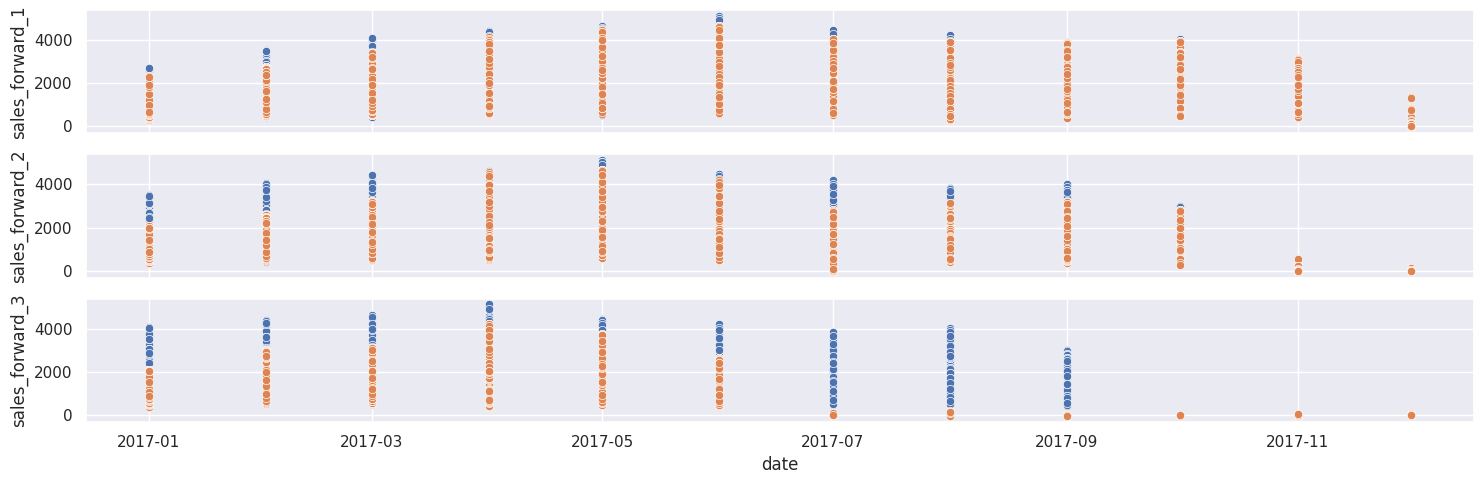

time: 1.42 s (started: 2023-06-14 17:30:23 +00:00)


In [42]:
show_predictions(y_test, y_pred)

## XGBRegressor

In [43]:
mor  = MultiOutputRegressor(estimator=XGBRegressor())
scores = custom_cross_val(mor, X_train, y_train, pipeline_cv)
show_scores(scores)

Smape scores: [43.53930900208071, 43.898488494111874, 44.26288635481125, 79.26872600134556]
Smape mean:   52.74
Smape std:    15.32
RMSE scores: [ 839.88893882  819.65061123  823.03461385 1067.50008218]
RMSE mean:   887.52
RMSE std:    104.19
time: 55.9 s (started: 2023-06-14 17:30:36 +00:00)


In [46]:
mor  = MultiOutputRegressor(estimator=XGBRegressor())
mor.fit(X_train_, y_train)
y_pred = mor.predict(X_test_)
print(f'SMAPE: {smape(y_test, y_pred):.2f}')
print(f'RMSE:  {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')

SMAPE: 65.75
RMSE:  825.50
time: 35.7 s (started: 2023-06-14 17:33:17 +00:00)


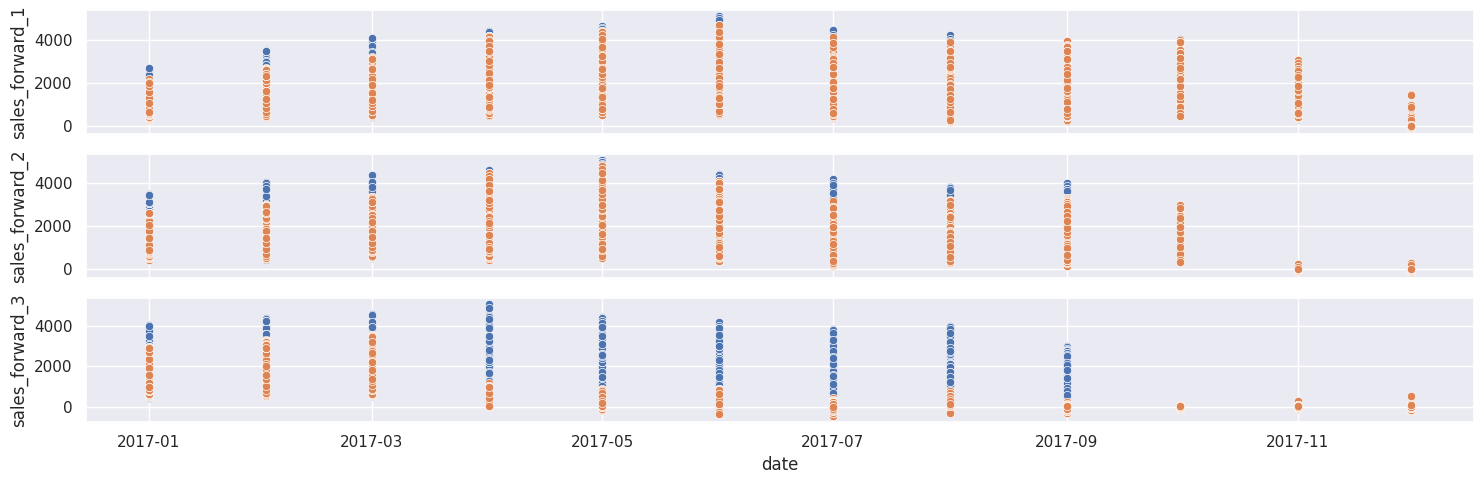

time: 1.91 s (started: 2023-06-14 17:34:10 +00:00)


In [47]:
show_predictions(y_test, y_pred)

## Neural Network

In [ ]:
nn = Sequential()
nn.add(Dense(units=2000, kernel_initializer="lecun_normal", activation='relu', input_shape=(X_train_.shape[1],)))
nn.add(Dense(units=2000, kernel_initializer="lecun_normal", activation='relu'))
nn.add(Dense(units=2000, kernel_initializer="lecun_normal", activation='relu'))
nn.add(Dense(units=3, activation='relu'))

time: 424 ms (started: 2023-06-13 00:26:30 +00:00)


In [ ]:
nn.compile(loss='mse', optimizer=Nadam(learning_rate=0.001), metrics=["mse"])
history = nn.fit(X_train_, y_train, epochs=150, verbose=False)

y_pred = nn.predict(X_test_)
print(f'SMAPE: {smape(y_test, y_pred):.2f}')
print(f'RMSE:  {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

188/188 [==============================] - 4s 21ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

nan
69.13443262810907
time: 3h 35min 51s (started: 2023-06-13 00:26:36 +00:00)


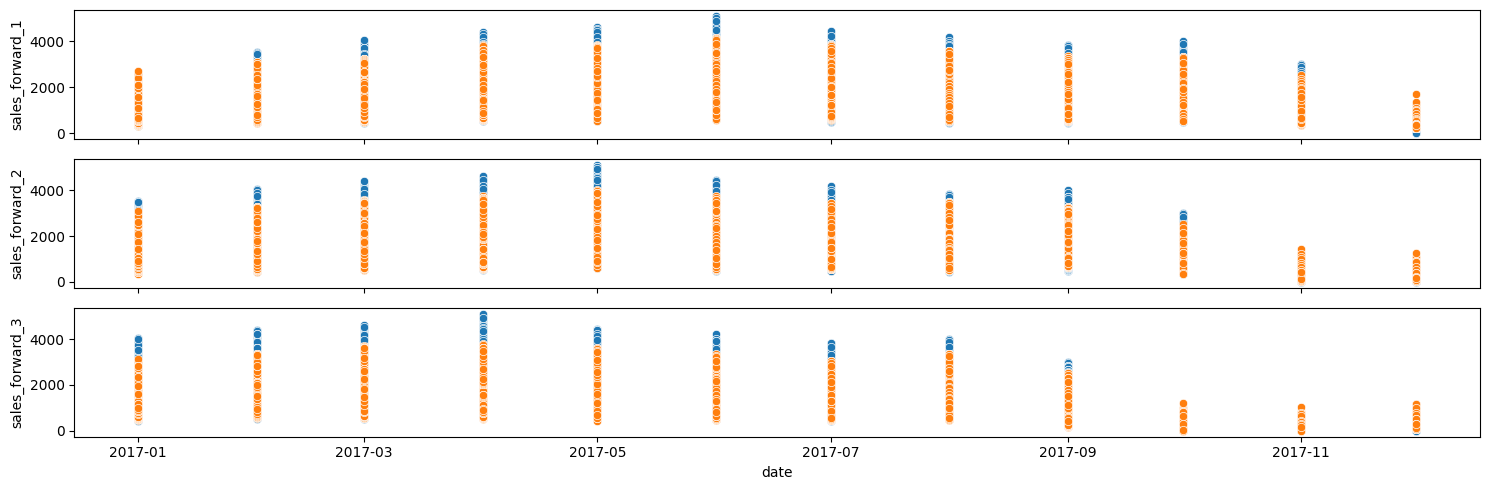

time: 13.1 s (started: 2023-06-12 19:05:14 +00:00)


In [ ]:
show_predictions(y_test, y_pred)

## LSTM

A primeira coisa que tenho que fazer é remodelar os conjuntos de treinamento e teste para que o LSTM possa ser usado. Para isso, preciso adicionar uma dimensão extra a eles.

In [48]:
X_train__ = X_train_.reshape(X_train_.shape[0], X_train_.shape[1], 1)
X_test__  = X_test_.reshape(X_test_.shape[0], X_test_.shape[1], 1)

time: 908 µs (started: 2023-06-14 17:34:34 +00:00)


In [49]:
#callbacks
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# performance scheduling
lr_performance = ReduceLROnPlateau(factor=0.3, patience=10)

time: 804 µs (started: 2023-06-14 17:34:36 +00:00)


In [50]:
nn = Sequential()
nn.add(LSTM(units=200, activation='relu', return_sequences=True, input_shape=(X_train__.shape[1], X_train__.shape[2])))
nn.add(LSTM(units=200, activation='relu'))
nn.add(Dense(units=3, activation='relu'))

nn.compile(loss='mse', optimizer=Nadam(learning_rate=0.001))

nn.fit(X_train__, y_train,
                 validation_data=(X_test__, y_test), epochs=150,
                 callbacks=[early_stopping_cb, lr_performance], verbose=True)

y_pred = nn.predict(X_test__)
print(f'SMAPE: {smape(y_test, y_pred):.2f}')
print(f'RMSE:  {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')

Epoch 1/150
750/750 [==============================] - 141s 184ms/step - loss: 125046432.0000 - val_loss: 656966.8750 - lr: 0.0010
Epoch 2/150
750/750 [==============================] - 147s 196ms/step - loss: 1071688.1250 - val_loss: 618091.4375 - lr: 0.0010
Epoch 3/150
750/750 [==============================] - 147s 195ms/step - loss: 235498.2656 - val_loss: 625745.8125 - lr: 0.0010
Epoch 4/150
750/750 [==============================] - 136s 181ms/step - loss: 2270392.5000 - val_loss: 3664987.7500 - lr: 0.0010
Epoch 5/150
750/750 [==============================] - 135s 180ms/step - loss: 2970342.7500 - val_loss: 3662861.2500 - lr: 0.0010
Epoch 6/150
750/750 [==============================] - 139s 185ms/step - loss: 7354919.0000 - val_loss: 729795.5625 - lr: 0.0010
Epoch 7/150
750/750 [==============================] - 146s 194ms/step - loss: 265158.7500 - val_loss: 610288.0000 - lr: 0.0010
Epoch 8/150
750/750 [==============================] - 131s 174ms/step - loss: 207494.5781 - va



---



# Resultado

RMSE

*   LightGBMRegressor: 604
*   XGBRegressor: 825
*   Neura Network: 69
*   LSTM: 227

O melhor modelo é o de redes neurais, apesar do enorme tempo de treinamento.
